<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка" data-toc-modified-id="Подготовка-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка</a></span></li><li><span><a href="#Анализ" data-toc-modified-id="Анализ-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Анализ</a></span></li><li><span><a href="#Обучение" data-toc-modified-id="Обучение-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Обучение</a></span></li><li><span><a href="#Тестирование" data-toc-modified-id="Тестирование-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Тестирование</a></span></li><li><span><a href="#Вывод" data-toc-modified-id="Вывод-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Вывод</a></span></li><li><span><a href="#Чек-лист-проверки" data-toc-modified-id="Чек-лист-проверки-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Чек-лист проверки</a></span></li></ul></div>

#  Прогнозирование заказов такси

Компания «Чётенькое такси» собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. Постройте модель для такого предсказания.

Значение метрики *RMSE* на тестовой выборке должно быть не больше 48.

Вам нужно:

1. Загрузить данные и выполнить их ресемплирование по одному часу.
2. Проанализировать данные.
3. Обучить разные модели с различными гиперпараметрами. Сделать тестовую выборку размером 10% от исходных данных.
4. Проверить данные на тестовой выборке и сделать выводы.


Данные лежат в файле `taxi.csv`. Количество заказов находится в столбце `num_orders` (от англ. *number of orders*, «число заказов»).

## Подготовка

In [74]:
import pandas as pd
import numpy as np
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error 
import matplotlib.pyplot as plt
from sklearn.metrics import fbeta_score, make_scorer
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV, cross_val_score
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor
import time

In [75]:
import warnings
warnings.filterwarnings("ignore")

In [76]:
data = pd.read_csv('/datasets/taxi.csv', index_col=[0], parse_dates=[0])

In [77]:
data.head()

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32


In [78]:
data.tail()

,num_orders
datetime,
2018-08-31 23:10:00,32
2018-08-31 23:20:00,24
2018-08-31 23:30:00,27
2018-08-31 23:40:00,39
2018-08-31 23:50:00,53


In [79]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0 KB


In [80]:
data.sort_index(inplace=True)

In [81]:
# проведем ресемплированание по одному часу

data = data.resample('1H').sum()

In [82]:
data.head()

,num_orders
datetime,
2018-03-01 00:00:00,124
2018-03-01 01:00:00,85
2018-03-01 02:00:00,71
2018-03-01 03:00:00,66
2018-03-01 04:00:00,43


In [83]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4416 entries, 2018-03-01 00:00:00 to 2018-08-31 23:00:00
Freq: H
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  4416 non-null   int64
dtypes: int64(1)
memory usage: 69.0 KB


## Анализ

Проведем анализ временного ряда

<AxesSubplot:xlabel='datetime'>

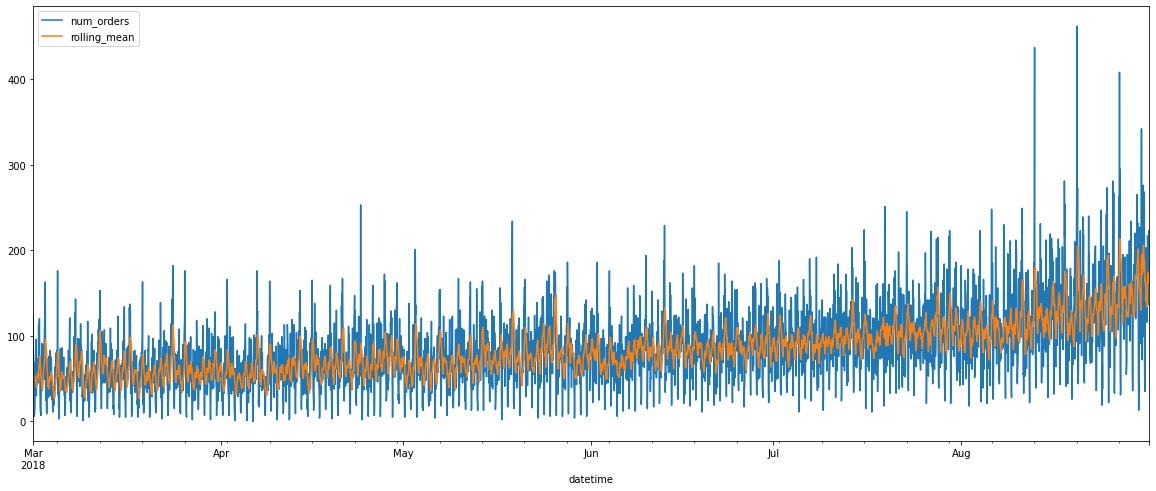

In [84]:
# Добавим в столбец 'rolling_mean' скользящее среднее с размером окна, равным 10



data['rolling_mean'] =data.rolling(10).mean() 
data.plot(figsize=(20, 8))

In [85]:
decomposed = seasonal_decompose(data.num_orders)

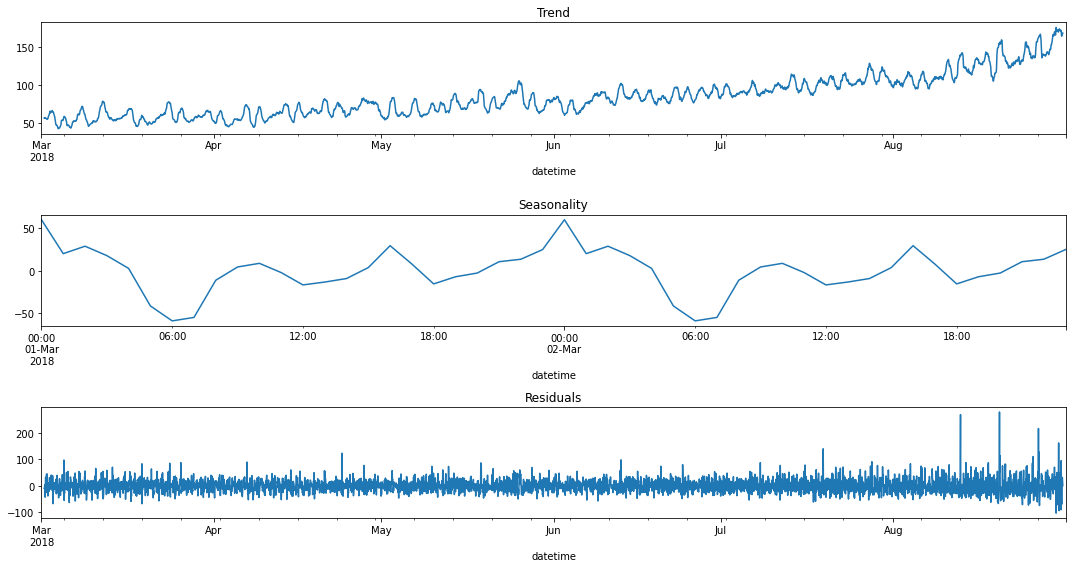

In [86]:
# Разложим временной ряд на тренд и сезонную компоненту. 


plt.figure(figsize=(15, 8))
plt.subplot(311)
decomposed.trend.plot(ax=plt.gca())
plt.title('Trend')
plt.subplot(312)
decomposed.seasonal['2018-03-01':'2018-03-02'].plot(ax=plt.gca()) # Построим график сезонной составляющей за 1 марта 2018 года
plt.title('Seasonality')
plt.subplot(313)
decomposed.resid.plot(ax=plt.gca()) 
plt.title('Residuals')
plt.tight_layout()

Из графика тренда мы видим тренд: увеличение заказов такси с конца зимы до самой осени. Летом люди чаще заказывают такси чем весной.

Из графика сезоннсти можно сделать вывод: люди активно заказывают такси утром когда едут на работу и учебу и вечером с 6 до 12 когда возвращаются домой. Ночью такси пользуется спросом, но этот спрос уменьшается к утру.

<AxesSubplot:xlabel='datetime'>

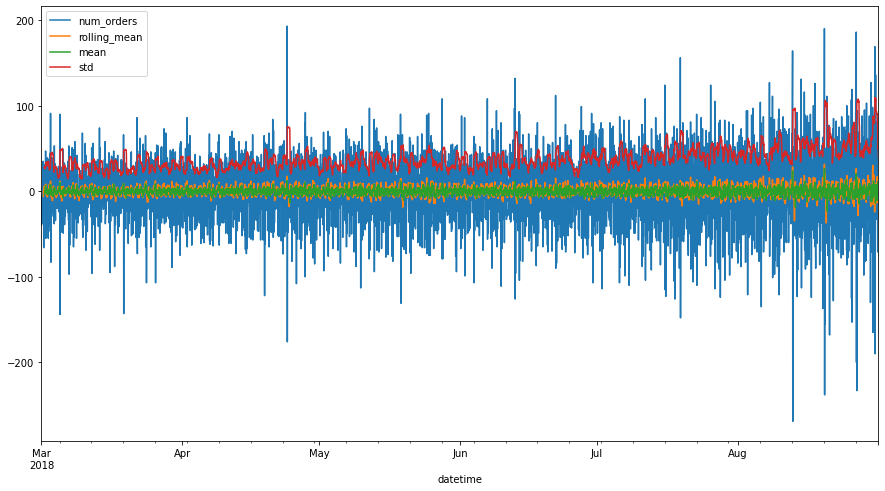

In [87]:
# Вычислим разности временного ряда. 
# На графике изобразим скользящее среднее и скользящее стандартное отклонение

df=data-data.shift()
df['mean'] = df['num_orders'].rolling(15).mean()
df['std'] = df['num_orders'].rolling(15).std()
df.plot(figsize=(15, 8))

## Обучение

In [88]:
# cоздадим признаки


def make_features(data, max_lag, rolling_mean_size):
    data['year'] = data.index.year
    data['month'] = data.index.month
    data['day'] = data.index.day
    data['dayofweek'] = data.index.dayofweek
    
    for lag in range(1, max_lag + 1):
        data['lag_{}'.format(lag)] = data['num_orders'].shift(lag)

    data['rolling_mean'] = data['num_orders'].shift().rolling(rolling_mean_size).mean()


make_features(data, 30, 30)

train, test = train_test_split(data, shuffle=False, test_size=0.1)
train = train.dropna()


features_train=train.drop(['num_orders'],axis=1)
target_train=train['num_orders']

features_test=test.drop(['num_orders'],axis=1)
target_test=test['num_orders']

In [89]:
features =data.drop(['num_orders'],axis=1)
target =data['num_orders']

## Тестирование

In [90]:
# создадм таблицу для подсчкета результатов

models_rating=[]

In [91]:
# Создадим функцию подсчета времени


def toFixed(numObj, digits=0):
    return f"{numObj:.{digits}f}"

In [92]:
start_1 = time.time()
model=DecisionTreeRegressor()
model.fit(features_train,target_train)
end_1 = time.time()

start_2 = time.time()
predict_test =model.predict(features_test)
end_2 = time.time()

mse=mean_squared_error(predict_test,target_test)
rmse=mse**0.5

print("rmse тестовой выборки: ", rmse)

rmse тестовой выборки:  64.62750909733948


In [93]:
models_rating.append({'model name': model.__class__.__name__, 
                              'rmse модели': rmse, 
                              'время обучения,c': toFixed(end_1 - start_1,2),
                              'время предсказания,c':toFixed(end_2 - start_2,2)}) 

In [94]:
# проверим модель линейной регрессии


start_1 = time.time()
model=LinearRegression()
model.fit(features_train,target_train)
end_1 = time.time()

start_2 = time.time()
predict_test =model.predict(features_test)
end_2 = time.time()

mse=mean_squared_error(predict_test,target_test)
rmse=mse**0.5

print("rmse тестовой выборки: ", rmse)

rmse тестовой выборки:  46.83078004733243


In [95]:
models_rating.append({'model name': model.__class__.__name__, 
                              'rmse модели': rmse, 
                              'время обучения,c': toFixed(end_1 - start_1,2),
                              'время предсказания,c':toFixed(end_2 - start_2,2)}) 

Параметры подбирались целых 8 минут.

In [96]:
%%time
# проверим модель случайного леса


start_1 = time.time()
model=RandomForestRegressor(max_depth= 35, n_estimators= 400)
model.fit(features_train,target_train)
end_1 = time.time()

start_2 = time.time()
predict_test =model.predict(features_test)
end_2 = time.time()

mse=mean_squared_error(predict_test,target_test)
rmse=mse**0.5

print("rmse тестовой выборки: ", rmse)

rmse тестовой выборки:  43.55370292317446
CPU times: user 23.4 s, sys: 76.1 ms, total: 23.5 s
Wall time: 23.6 s


Зато мы получили отличное значение метрики.

In [97]:
models_rating.append({'model name': model.__class__.__name__, 
                              'rmse модели': rmse, 
                              'время обучения,c': toFixed(end_1 - start_1,2),
                              'время предсказания,c':toFixed(end_2 - start_2,2)}) 

In [98]:
%%time

# подберем параметры для RandomForestRegressor 


estimator = LGBMRegressor()

param_grid = {
    
    'n_estimators': [153,155,157],
    'learning_rate': [0.04, 0.05]

}

gbm = GridSearchCV(estimator, param_grid,cv=TimeSeriesSplit(n_splits=2), verbose=1)

gbm.fit(features_train, target_train)

print('Best parameters found by grid search are:', gbm.best_params_)

Fitting 2 folds for each of 6 candidates, totalling 12 fits
Best parameters found by grid search are: {'learning_rate': 0.05, 'n_estimators': 155}
CPU times: user 2min 41s, sys: 777 ms, total: 2min 42s
Wall time: 2min 44s


In [99]:
%%time
# проверим модель случайного леса


start_1 = time.time()
model=LGBMRegressor(learning_rate= 0.05, n_estimators= 155)
model.fit(features_train,target_train)
end_1 = time.time()

start_2 = time.time()
predict_test =model.predict(features_test)
end_2 = time.time()

mse=mean_squared_error(predict_test,target_test)
rmse=mse**0.5

print("rmse тестовой выборки: ", rmse)

rmse тестовой выборки:  43.12787388976872
CPU times: user 1.77 s, sys: 24.9 ms, total: 1.79 s
Wall time: 1.89 s


In [100]:
models_rating.append({'model name': model.__class__.__name__, 
                              'rmse модели': rmse, 
                              'время обучения,c': toFixed(end_1 - start_1,2),
                              'время предсказания,c':toFixed(end_2 - start_2,2)}) 

In [101]:
%%time
# подберем параметры для RandomForestRegressor 


estimator = CatBoostRegressor(verbose=False)

param_grid = {
    
    'n_estimators': [300,330,340],
    'learning_rate': [0.01, 0.1]

}

gbm = GridSearchCV(estimator, param_grid,cv=TimeSeriesSplit(n_splits=2), verbose=1)

gbm.fit(features_train, target_train)

print('Best parameters found by grid search are:', gbm.best_params_)

Fitting 2 folds for each of 6 candidates, totalling 12 fits
Best parameters found by grid search are: {'learning_rate': 0.1, 'n_estimators': 330}
CPU times: user 22 s, sys: 663 ms, total: 22.7 s
Wall time: 34 s


In [102]:
%%time
# проверим модель случайного леса


start_1 = time.time()
model=CatBoostRegressor(learning_rate= 0.1, n_estimators= 330, verbose=False)
model.fit(features_train,target_train)
end_1 = time.time()


start_2 = time.time()
predict_test =model.predict(features_test)
end_2 = time.time()

mse=mean_squared_error(predict_test,target_test)
rmse=mse**0.5

print("rmse тестовой выборки: ", rmse)

rmse тестовой выборки:  41.520155989599736
CPU times: user 2.29 s, sys: 34.8 ms, total: 2.33 s
Wall time: 3.21 s


In [103]:
models_rating.append({'model name': model.__class__.__name__, 
                              'rmse модели': rmse, 
                              'время обучения,c': toFixed(end_1 - start_1,2),
                              'время предсказания,c':toFixed(end_2 - start_2,2)}) 

## Вывод

In [104]:
pd.DataFrame(models_rating).sort_values(by=['rmse модели'])

,model name,rmse модели,"время обучения,c","время предсказания,c"
4,CatBoostRegressor,41.520156,3.21,0.00
3,LGBMRegressor,43.127874,1.80,0.09
2,RandomForestRegressor,43.553703,23.50,0.06
1,LinearRegression,46.830780,0.02,0.20
0,DecisionTreeRegressor,64.627509,0.12,0.00


По итогу можно сделать вывод что лучшее значение метрики дала модель CatBoostRegressor, со временем обучания 3с. 